In [1]:
import urllib.request
import urllib.error
import urllib.parse
import re
import pymongo
import jieba
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import json
import requests
import time
from random import choice
from multiprocessing import Pool
import warnings
from retrying import retry

warnings.filterwarnings('ignore')

In [2]:
AGENTS_ALL = [
    "Avant Browser/1.2.789rel1 (http://www.avantbrowser.com)",
    "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/532.5 (KHTML, like Gecko) Chrome/4.0.249.0 Safari/532.5",
    "Mozilla/5.0 (Windows; U; Windows NT 5.2; en-US) AppleWebKit/532.9 (KHTML, like Gecko) Chrome/5.0.310.0 Safari/532.9",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/534.7 (KHTML, like Gecko) Chrome/7.0.514.0 Safari/534.7",
    "Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US) AppleWebKit/534.14 (KHTML, like Gecko) Chrome/9.0.601.0 Safari/534.14",
    "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/534.14 (KHTML, like Gecko) Chrome/10.0.601.0 Safari/534.14",
    "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/534.20 (KHTML, like Gecko) Chrome/11.0.672.2 Safari/534.20",
    "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/534.27 (KHTML, like Gecko) Chrome/12.0.712.0 Safari/534.27",
    "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/13.0.782.24 Safari/535.1",
    "Mozilla/5.0 (Windows NT 6.0) AppleWebKit/535.2 (KHTML, like Gecko) Chrome/15.0.874.120 Safari/535.2",
    "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.7 (KHTML, like Gecko) Chrome/16.0.912.36 Safari/535.7",
    "Mozilla/5.0 (Windows; U; Windows NT 6.0 x64; en-US; rv:1.9pre) Gecko/2008072421 Minefield/3.0.2pre",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.9.0.10) Gecko/2009042316 Firefox/3.0.10",
    "Mozilla/5.0 (Windows; U; Windows NT 6.0; en-GB; rv:1.9.0.11) Gecko/2009060215 Firefox/3.0.11 (.NET CLR 3.5.30729)",
    "Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US; rv:1.9.1.6) Gecko/20091201 Firefox/3.5.6 GTB5",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; tr; rv:1.9.2.8) Gecko/20100722 Firefox/3.6.8 ( .NET CLR 3.5.30729; .NET4.0E)",
    "Mozilla/5.0 (Windows NT 6.1; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (Windows NT 5.1; rv:5.0) Gecko/20100101 Firefox/5.0",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:6.0a2) Gecko/20110622 Firefox/6.0a2",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:7.0.1) Gecko/20100101 Firefox/7.0.1",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:2.0b4pre) Gecko/20100815 Minefield/4.0b4pre",
    "Mozilla/4.0 (compatible; MSIE 5.5; Windows NT 5.0 )",
    "Mozilla/4.0 (compatible; MSIE 5.5; Windows 98; Win 9x 4.90)",
    "Mozilla/5.0 (Windows; U; Windows XP) Gecko MultiZilla/1.6.1.0a",
    "Mozilla/2.02E (Win95; U)",
    "Mozilla/3.01Gold (Win95; I)",
    "Mozilla/4.8 [en] (Windows NT 5.1; U)",
    "Mozilla/5.0 (Windows; U; Win98; en-US; rv:1.4) Gecko Netscape/7.1 (ax)",
    "Opera/7.50 (Windows XP; U)",
    "Opera/7.50 (Windows ME; U) [en]",
    "Opera/7.51 (Windows NT 5.1; U) [en]",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.0; en) Opera 8.0",
    "Mozilla/5.0 (Windows; U; WinNT4.0; en-US; rv:1.2b) Gecko/20021001 Phoenix/0.2",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; rv:1.8.1.23) Gecko/20090825 SeaMonkey/1.1.18",
    "Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US) AppleWebKit/527  (KHTML, like Gecko, Safari/419.3) Arora/0.6 (Change: )",
    "Mozilla/5.0 (Windows; U; ; en-NZ) AppleWebKit/527  (KHTML, like Gecko, Safari/419.3) Arora/0.8.0",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; Avant Browser; Avant Browser; .NET CLR 1.0.3705; .NET CLR 1.1.4322; Media Center PC 4.0; .NET CLR 2.0.50727; .NET CLR 3.0.04506.30)",
    "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/535.8 (KHTML, like Gecko) Beamrise/17.2.0.9 Chrome/17.0.939.0 Safari/535.8",
    "Mozilla/5.0 (Windows NT 6.1) AppleWebKit/535.2 (KHTML, like Gecko) Chrome/18.6.872.0 Safari/535.2 UNTRUSTED/1.0 3gpp-gba UNTRUSTED/1.0",
    "Mozilla/5.0 (Windows NT 6.2) AppleWebKit/536.3 (KHTML, like Gecko) Chrome/19.0.1061.1 Safari/536.3",
    "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/536.6 (KHTML, like Gecko) Chrome/20.0.1092.0 Safari/536.6",
    "Mozilla/5.0 (Windows NT 6.2) AppleWebKit/536.6 (KHTML, like Gecko) Chrome/20.0.1090.0 Safari/536.6",
    "Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.1 (KHTML, like Gecko) Chrome/22.0.1207.1 Safari/537.1",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:10.0.1) Gecko/20100101 Firefox/10.0.1",
    "Mozilla/5.0 (Windows NT 6.1; rv:12.0) Gecko/20120403211507 Firefox/12.0",
    "Mozilla/5.0 (Windows NT 6.0; rv:14.0) Gecko/20100101 Firefox/14.0.1",
    "Mozilla/5.0 (Windows NT 6.1; WOW64; rv:15.0) Gecko/20120427 Firefox/15.0a1",
    "Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0) Gecko/16.0 Firefox/16.0",
    "iTunes/9.0.2 (Windows; N)",
    "Mozilla/5.0 (compatible; Konqueror/4.5; Windows) KHTML/4.5.4 (like Gecko)",
    "Mozilla/5.0 (Windows; U; Windows NT 6.0; en-US) AppleWebKit/533.1 (KHTML, like Gecko) Maxthon/3.0.8.2 Safari/533.1",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1)",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0)",
    "Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.1; Trident/4.0)",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0; Trident/4.0)",
    "Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6.0; Trident/4.0)",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.0; Trident/5.0)",
    "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.1; Trident/5.0)",
    "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; Trident/5.0)",
    "Mozilla/5.0 (compatible; MSIE 9.0; Windows NT 6.2; WOW64; Trident/5.0)",
    "Mozilla/5.0 (compatible; MSIE 10.0; Windows NT 6.1; WOW64; Trident/6.0)",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 6.1; Trident/6.0)",
    "Mozilla/5.0 (compatible; MSIE 10.6; Windows NT 6.1; Trident/5.0; InfoPath.2; SLCC1; .NET CLR 3.0.4506.2152; .NET CLR 3.5.30729; .NET CLR 2.0.50727) 3gpp-gba UNTRUSTED/1.0",
    "Opera/9.25 (Windows NT 6.0; U; en)",
    "Opera/9.80 (Windows NT 5.2; U; en) Presto/2.2.15 Version/10.10",
    "Opera/9.80 (Windows NT 5.1; U; ru) Presto/2.7.39 Version/11.00",
    "Opera/9.80 (Windows NT 6.1; U; en) Presto/2.7.62 Version/11.01",
    "Opera/9.80 (Windows NT 5.1; U; zh-tw) Presto/2.8.131 Version/11.10",
    "Opera/9.80 (Windows NT 6.1; U; es-ES) Presto/2.9.181 Version/12.00",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US) AppleWebKit/531.21.8 (KHTML, like Gecko) Version/4.0.4 Safari/531.21.10",
    "Mozilla/5.0 (Windows; U; Windows NT 5.2; en-US) AppleWebKit/533.17.8 (KHTML, like Gecko) Version/5.0.1 Safari/533.17.8",
    "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US) AppleWebKit/533.19.4 (KHTML, like Gecko) Version/5.0.2 Safari/533.18.5",
    "Mozilla/5.0 (Windows; U; Windows NT 6.1; en-GB; rv:1.9.1.17) Gecko/20110123 (like Firefox/3.x) SeaMonkey/2.0.12",
    "Mozilla/5.0 (Windows NT 5.2; rv:10.0.1) Gecko/20100101 Firefox/10.0.1 SeaMonkey/2.7.1",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5_8; en-US) AppleWebKit/532.8 (KHTML, like Gecko) Chrome/4.0.302.2 Safari/532.8",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_4; en-US) AppleWebKit/534.3 (KHTML, like Gecko) Chrome/6.0.464.0 Safari/534.3",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_5; en-US) AppleWebKit/534.13 (KHTML, like Gecko) Chrome/9.0.597.15 Safari/534.13",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_2) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/14.0.835.186 Safari/535.1",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/535.2 (KHTML, like Gecko) Chrome/15.0.874.54 Safari/535.2",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_6_8) AppleWebKit/535.7 (KHTML, like Gecko) Chrome/16.0.912.36 Safari/535.7",
    "Mozilla/5.0 (Macintosh; U; Mac OS X Mach-O; en-US; rv:2.0a) Gecko/20040614 Firefox/3.0.0 ",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10.5; en-US; rv:1.9.0.3) Gecko/2008092414 Firefox/3.0.3",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.5; en-US; rv:1.9.1) Gecko/20090624 Firefox/3.5",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10.6; en-US; rv:1.9.2.14) Gecko/20110218 AlexaToolbar/alxf-2.0 Firefox/3.6.14",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X 10.5; en-US; rv:1.9.2.15) Gecko/20110303 Firefox/3.6.15",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:5.0) Gecko/20100101 Firefox/5.0",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:9.0) Gecko/20100101 Firefox/9.0",
    "Mozilla/4.0 (compatible; MSIE 5.15; Mac_PowerPC)",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X; en-US) AppleWebKit/125.4 (KHTML, like Gecko, Safari) OmniWeb/v563.15",
    "Opera/9.0 (Macintosh; PPC Mac OS X; U; en)",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X; en) AppleWebKit/125.2 (KHTML, like Gecko) Safari/85.8",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X; en) AppleWebKit/125.2 (KHTML, like Gecko) Safari/125.8",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X; fr-fr) AppleWebKit/312.5 (KHTML, like Gecko) Safari/312.3",
    "Mozilla/5.0 (Macintosh; U; PPC Mac OS X; en) AppleWebKit/418.8 (KHTML, like Gecko) Safari/419.3",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:2.0.1) Gecko/20100101 Firefox/4.0.1 Camino/2.2.1",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.6; rv:2.0b6pre) Gecko/20100907 Firefox/4.0b6pre Camino/2.2a1pre",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_0) AppleWebKit/536.3 (KHTML, like Gecko) Chrome/19.0.1063.0 Safari/536.3",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_8_2) AppleWebKit/537.4 (KHTML like Gecko) Chrome/22.0.1229.79 Safari/537.4",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_2; rv:10.0.1) Gecko/20100101 Firefox/10.0.1",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.8; rv:16.0) Gecko/20120813 Firefox/16.0",
    "iTunes/4.2 (Macintosh; U; PPC Mac OS X 10.2)",
    "iTunes/9.0.3 (Macintosh; U; Intel Mac OS X 10_6_2; en-ca)",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X; en-US) AppleWebKit/528.16 (KHTML, like Gecko, Safari/528.16) OmniWeb/v622.8.0.112941",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5_6; en-US) AppleWebKit/528.16 (KHTML, like Gecko, Safari/528.16) OmniWeb/v622.8.0",
    "Opera/9.20 (Macintosh; Intel Mac OS X; U; en)",
    "Opera/9.64 (Macintosh; PPC Mac OS X; U; en) Presto/2.1.1",
    "Opera/9.80 (Macintosh; Intel Mac OS X; U; en) Presto/2.6.30 Version/10.61",
    "Opera/9.80 (Macintosh; Intel Mac OS X 10.4.11; U; en) Presto/2.7.62 Version/11.00",
    "Opera/9.80 (Macintosh; Intel Mac OS X 10.6.8; U; fr) Presto/2.9.168 Version/11.52",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_2; en-us) AppleWebKit/531.21.8 (KHTML, like Gecko) Version/4.0.4 Safari/531.21.10",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_5; de-de) AppleWebKit/534.15  (KHTML, like Gecko) Version/5.0.3 Safari/533.19.4",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_6_6; en-us) AppleWebKit/533.20.25 (KHTML, like Gecko) Version/5.0.4 Safari/533.20.27",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_7; en-us) AppleWebKit/534.20.8 (KHTML, like Gecko) Version/5.1 Safari/534.20.8",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_7_3) AppleWebKit/534.55.3 (KHTML, like Gecko) Version/5.1.3 Safari/534.53.10",
    "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.5; rv:10.0.1) Gecko/20100101 Firefox/10.0.1 SeaMonkey/2.7.1",
    "ELinks (0.4pre5; Linux 2.6.10-ac7 i686; 80x33)",
    "ELinks/0.9.3 (textmode; Linux 2.6.9-kanotix-8 i686; 127x41)",
    "ELinks/0.12~pre5-4",
    "Links/0.9.1 (Linux 2.4.24; i386;)",
    "Links (2.1pre15; Linux 2.4.26 i686; 158x61)",
    "Links (2.3pre1; Linux 2.6.38-8-generic x86_64; 170x48)",
    "Lynx/2.8.5rel.1 libwww-FM/2.14 SSL-MM/1.4.1 GNUTLS/0.8.12",
    "w3m/0.5.1",
    "Mozilla/5.0 (X11; U; Linux i686; en-US) AppleWebKit/532.4 (KHTML, like Gecko) Chrome/4.0.237.0 Safari/532.4 Debian",
    "Mozilla/5.0 (X11; U; Linux i686; en-US) AppleWebKit/532.8 (KHTML, like Gecko) Chrome/4.0.277.0 Safari/532.8",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US) AppleWebKit/532.9 (KHTML, like Gecko) Chrome/5.0.309.0 Safari/532.9",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US) AppleWebKit/534.7 (KHTML, like Gecko) Chrome/7.0.514.0 Safari/534.7",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US) AppleWebKit/540.0 (KHTML, like Gecko) Ubuntu/10.10 Chrome/9.1.0.0 Safari/540.0",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US) AppleWebKit/534.15 (KHTML, like Gecko) Chrome/10.0.613.0 Safari/534.15",
    "Mozilla/5.0 (X11; U; Linux i686; en-US) AppleWebKit/534.15 (KHTML, like Gecko) Ubuntu/10.10 Chromium/10.0.613.0 Chrome/10.0.613.0 Safari/534.15",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/534.24 (KHTML, like Gecko) Ubuntu/10.10 Chromium/12.0.703.0 Chrome/12.0.703.0 Safari/534.24",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/13.0.782.20 Safari/535.1",
    "Mozilla/5.0 Slackware/13.37 (X11; U; Linux x86_64; en-US) AppleWebKit/535.1 (KHTML, like Gecko) Chrome/13.0.782.41",
    "Mozilla/5.0 (X11; Linux i686) AppleWebKit/535.1 (KHTML, like Gecko) Ubuntu/11.04 Chromium/14.0.825.0 Chrome/14.0.825.0 Safari/535.1",
    "Mozilla/5.0 (X11; Linux i686) AppleWebKit/535.2 (KHTML, like Gecko) Ubuntu/11.10 Chromium/15.0.874.120 Chrome/15.0.874.120 Safari/535.2",
    "Mozilla/5.0 (X11; U; Linux; i686; en-US; rv:1.6) Gecko Epiphany/1.2.5",
    "Mozilla/5.0 (X11; U; Linux i586; en-US; rv:1.7.3) Gecko/20040924 Epiphany/1.4.4 (Ubuntu)",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.6) Gecko/20040614 Firefox/0.8",
    "Mozilla/5.0 (X11; U; Linux x86_64; sv-SE; rv:1.8.1.12) Gecko/20080207 Ubuntu/7.10 (gutsy) Firefox/2.0.0.12",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.11) Gecko/2009060309 Ubuntu/9.10 (karmic) Firefox/3.0.11",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.1.2) Gecko/20090803 Ubuntu/9.04 (jaunty) Shiretoko/3.5.2",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.1.5) Gecko/20091107 Firefox/3.5.5",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.1.3) Gecko/20091020 Linux Mint/8 (Helena) Firefox/3.5.3",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.2.9) Gecko/20100915 Gentoo Firefox/3.6.9",
    "Mozilla/5.0 (X11; U; Linux i686; pl-PL; rv:1.9.0.2) Gecko/20121223 Ubuntu/9.25 (jaunty) Firefox/3.8",
    "Mozilla/5.0 (X11; Linux i686; rv:2.0b6pre) Gecko/20100907 Firefox/4.0b6pre",
    "Mozilla/5.0 (X11; Linux i686 on x86_64; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (X11; Linux i686; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (X11; Linux x86_64; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (X11; Linux x86_64; rv:2.2a1pre) Gecko/20100101 Firefox/4.2a1pre",
    "Mozilla/5.0 (X11; Linux i686; rv:5.0) Gecko/20100101 Firefox/5.0",
    "Mozilla/5.0 (X11; Linux i686; rv:6.0) Gecko/20100101 Firefox/6.0",
    "Mozilla/5.0 (X11; Linux x86_64; rv:7.0a1) Gecko/20110623 Firefox/7.0a1",
    "Mozilla/5.0 (X11; Linux i686; rv:8.0) Gecko/20100101 Firefox/8.0",
    "Mozilla/5.0 (X11; Linux x86_64; rv:10.0.1) Gecko/20100101 Firefox/10.0.1",
    "Mozilla/5.0 (X11; U; Linux; i686; en-US; rv:1.6) Gecko Galeon/1.3.14",
    "Mozilla/5.0 (X11; U; Linux ppc; en-US; rv:1.8.1.13) Gecko/20080313 Iceape/1.1.9 (Debian-1.1.9-5)",
    "Mozilla/5.0 (X11; U; Linux i686; pt-PT; rv:1.9.2.3) Gecko/20100402 Iceweasel/3.6.3 (like Firefox/3.6.3) GTB7.0",
    "Mozilla/5.0 (X11; Linux x86_64; rv:5.0) Gecko/20100101 Firefox/5.0 Iceweasel/5.0",
    "Mozilla/5.0 (X11; Linux i686; rv:6.0a2) Gecko/20110615 Firefox/6.0a2 Iceweasel/6.0a2",
    "Konqueror/3.0-rc4; (Konqueror/3.0-rc4; i686 Linux;;datecode)",
    "Mozilla/5.0 (compatible; Konqueror/3.3; Linux 2.6.8-gentoo-r3; X11;",
    "Mozilla/5.0 (compatible; Konqueror/3.5; Linux 2.6.30-7.dmz.1-liquorix-686; X11) KHTML/3.5.10 (like Gecko) (Debian package 4:3.5.10.dfsg.1-1 b1)",
    "Mozilla/5.0 (compatible; Konqueror/3.5; Linux; en_US) KHTML/3.5.6 (like Gecko) (Kubuntu)",
    "Mozilla/5.0 (X11; Linux x86_64; en-US; rv:2.0b2pre) Gecko/20100712 Minefield/4.0b2pre",
    "Mozilla/5.0 (X11; U; Linux; i686; en-US; rv:1.6) Gecko Debian/1.6-7",
    "MSIE (MSIE 6.0; X11; Linux; i686) Opera 7.23",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.1) Gecko/20061024 Firefox/2.0 (Swiftfox)",
    "Mozilla/5.0 (X11; U; Linux; en-US) AppleWebKit/527  (KHTML, like Gecko, Safari/419.3) Arora/0.10.1",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/536.5 (KHTML, like Gecko) Chrome/19.0.1084.9 Safari/536.5",
    "Mozilla/5.0 (X11; CrOS i686 2268.111.0) AppleWebKit/536.11 (KHTML, like Gecko) Chrome/20.0.1132.57 Safari/536.11",
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.4 (KHTML like Gecko) Chrome/22.0.1229.56 Safari/537.4",
    "Mozilla/4.0 (compatible; Dillo 3.0)",
    "Mozilla/5.0 (X11; U; Linux i686; en-us) AppleWebKit/528.5  (KHTML, like Gecko, Safari/528.5 ) lt-GtkLauncher",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.1.16) Gecko/20120421 Gecko Firefox/11.0",
    "Mozilla/5.0 (X11; Linux i686; rv:12.0) Gecko/20100101 Firefox/12.0 ",
    "Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:14.0) Gecko/20100101 Firefox/14.0.1",
    "Mozilla/5.0 (X11; Linux i686; rv:16.0) Gecko/20100101 Firefox/16.0",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9.0.8) Gecko Galeon/2.0.6 (Ubuntu 2.0.6-2)",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.1.16) Gecko/20080716 (Gentoo) Galeon/2.0.6",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.1.13) Gecko/20100916 Iceape/2.0.8",
    "Mozilla/5.0 (X11; Linux i686; rv:14.0) Gecko/20100101 Firefox/14.0.1 Iceweasel/14.0.1",
    "Mozilla/5.0 (X11; Linux x86_64; rv:15.0) Gecko/20120724 Debian Iceweasel/15.02",
    "Mozilla/5.0 (compatible; Konqueror/4.2; Linux) KHTML/4.2.4 (like Gecko) Slackware/13.0",
    "Mozilla/5.0 (compatible; Konqueror/4.3; Linux) KHTML/4.3.1 (like Gecko) Fedora/4.3.1-3.fc11",
    "Mozilla/5.0 (compatible; Konqueror/4.4; Linux) KHTML/4.4.1 (like Gecko) Fedora/4.4.1-1.fc12",
    "Mozilla/5.0 (compatible; Konqueror/4.4; Linux 2.6.32-22-generic; X11; en_US) KHTML/4.4.3 (like Gecko) Kubuntu",
    "Midori/0.1.10 (X11; Linux i686; U; en-us) WebKit/(531).(2) ",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.0.3) Gecko/2008092814 (Debian-3.0.1-1)",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.9a3pre) Gecko/20070330",
    "Opera/9.64 (X11; Linux i686; U; Linux Mint; nb) Presto/2.1.1",
    "Opera/9.80 (X11; Linux i686; U; en) Presto/2.2.15 Version/10.10",
    "Opera/9.80 (X11; Linux x86_64; U; pl) Presto/2.7.62 Version/11.00",
    "Mozilla/5.0 (X11; Linux i686) AppleWebKit/534.34 (KHTML, like Gecko) QupZilla/1.2.0 Safari/534.34",
    "Mozilla/5.0 (X11; U; Linux x86_64; en-US; rv:1.9.1.17) Gecko/20110123 SeaMonkey/2.0.12",
    "Mozilla/5.0 (X11; Linux i686; rv:10.0.1) Gecko/20100101 Firefox/10.0.1 SeaMonkey/2.7.1",
    "Mozilla/5.0 (X11; U; Linux x86_64; us; rv:1.9.1.19) Gecko/20110430 shadowfox/7.0 (like Firefox/7.0",
    "Mozilla/5.0 (X11; U; Linux i686; it; rv:1.9.2.3) Gecko/20100406 Firefox/3.6.3 (Swiftfox)",
    "Uzbl (Webkit 1.3) (Linux i686 [i686])",
    "ELinks (0.4.3; NetBSD 3.0.2PATCH sparc64; 141x19)",
    "Links (2.1pre15; FreeBSD 5.3-RELEASE i386; 196x84)",
    "Lynx/2.8.7dev.4 libwww-FM/2.14 SSL-MM/1.4.1 OpenSSL/0.9.8d",
    "w3m/0.5.1",
    "Mozilla/5.0 (X11; U; FreeBSD i386; en-US) AppleWebKit/532.0 (KHTML, like Gecko) Chrome/4.0.207.0 Safari/532.0",
    "Mozilla/5.0 (X11; U; OpenBSD i386; en-US) AppleWebKit/533.3 (KHTML, like Gecko) Chrome/5.0.359.0 Safari/533.3",
    "Mozilla/5.0 (X11; U; FreeBSD x86_64; en-US) AppleWebKit/534.16 (KHTML, like Gecko) Chrome/10.0.648.204 Safari/534.16",
    "Mozilla/5.0 (X11; U; SunOS sun4m; en-US; rv:1.4b) Gecko/20030517 Mozilla Firebird/0.6",
    "Mozilla/5.0 (X11; U; FreeBSD i386; en-US; rv:1.6) Gecko/20040406 Galeon/1.3.15",
    "Mozilla/5.0 (compatible; Konqueror/3.5; NetBSD 4.0_RC3; X11) KHTML/3.5.7 (like Gecko)",
    "Mozilla/5.0 (compatible; Konqueror/3.5; SunOS) KHTML/3.5.1 (like Gecko)",
    "Mozilla/5.0 (X11; U; FreeBSD; i386; en-US; rv:1.7) Gecko",
    "Mozilla/4.77 [en] (X11; I; IRIX;64 6.5 IP30)",
    "Mozilla/4.8 [en] (X11; U; SunOS; 5.7 sun4u)",
    "Mozilla/5.0 (Unknown; U; UNIX BSD/SYSV system; C -) AppleWebKit/527  (KHTML, like Gecko, Safari/419.3) Arora/0.10.2",
    "Mozilla/5.0 (X11; FreeBSD amd64) AppleWebKit/536.5 (KHTML like Gecko) Chrome/19.0.1084.56 Safari/536.5",
    "Mozilla/5.0 (X11; FreeBSD amd64) AppleWebKit/537.4 (KHTML like Gecko) Chrome/22.0.1229.79 Safari/537.4",
    "Mozilla/5.0 (X11; U; OpenBSD arm; en-us) AppleWebKit/531.2  (KHTML, like Gecko) Safari/531.2  Epiphany/2.30.0",
    "Mozilla/5.0 (X11; U; FreeBSD amd64; en-us) AppleWebKit/531.2  (KHTML, like Gecko) Safari/531.2  Epiphany/2.30.0",
    "Mozilla/5.0 (X11; U; SunOS i86pc; en-US; rv:1.9.1b3) Gecko/20090429 Firefox/3.1b3",
    "Mozilla/5.0 (X11; U; OpenBSD i386; en-US; rv:1.9.1) Gecko/20090702 Firefox/3.5",
    "Mozilla/5.0 (X11; U; FreeBSD i386; de-CH; rv:1.9.2.8) Gecko/20100729 Firefox/3.6.8",
    "Mozilla/5.0 (X11; FreeBSD amd64; rv:5.0) Gecko/20100101 Firefox/5.0",
    "Mozilla/5.0 (compatible; Konqueror/4.1; DragonFly) KHTML/4.1.4 (like Gecko)",
    "Mozilla/5.0 (compatible; Konqueror/4.1; OpenBSD) KHTML/4.1.4 (like Gecko)",
    "Mozilla/5.0 (compatible; Konqueror/4.5; NetBSD 5.0.2; X11; amd64; en_US) KHTML/4.5.4 (like Gecko)",
    "Mozilla/5.0 (compatible; Konqueror/4.5; FreeBSD) KHTML/4.5.4 (like Gecko)",
    "Mozilla/5.0 (X11; U; NetBSD amd64; en-US; rv:1.9.2.15) Gecko/20110308 Namoroka/3.6.15",
    "NetSurf/1.2 (NetBSD; amd64)",
    "Opera/9.80 (X11; FreeBSD 8.1-RELEASE i386; Edition Next) Presto/2.12.388 Version/12.10",
    "Mozilla/5.0 (X11; U; SunOS i86pc; en-US; rv:1.8.1.12) Gecko/20080303 SeaMonkey/1.1.8",
    "Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US; BOLT/2.800) AppleWebKit/534.6 (KHTML, like Gecko) Version/5.0 Safari/534.6.3",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows CE; IEMobile 6.12; Microsoft ZuneHD 4.3)",
    "Mozilla/1.22 (compatible; MSIE 5.01; PalmOS 3.0) EudoraWeb 2.1",
    "Mozilla/5.0 (WindowsCE 6.0; rv:2.0.1) Gecko/20100101 Firefox/4.0.1",
    "Mozilla/5.0 (X11; U; Linux armv61; en-US; rv:1.9.1b2pre) Gecko/20081015 Fennec/1.0a1",
    "Mozilla/5.0 (Maemo; Linux armv7l; rv:2.0.1) Gecko/20100101 Firefox/4.0.1 Fennec/2.0.1",
    "Mozilla/5.0 (Maemo; Linux armv7l; rv:10.0.1) Gecko/20100101 Firefox/10.0.1 Fennec/10.0.1",
    "Mozilla/5.0 (Windows; U; Windows CE 5.1; rv:1.8.1a3) Gecko/20060610 Minimo/0.016",
    "Mozilla/5.0 (X11; U; Linux armv6l; rv 1.8.1.5pre) Gecko/20070619 Minimo/0.020",
    "Mozilla/5.0 (X11; U; Linux arm7tdmi; rv:1.8.1.11) Gecko/20071130 Minimo/0.025",
    "Mozilla/4.0 (PDA; PalmOS/sony/model prmr/Revision:1.1.54 (en)) NetFront/3.0",
    "Opera/9.51 Beta (Microsoft Windows; PPC; Opera Mobi/1718; U; en)",
    "Opera/9.60 (J2ME/MIDP; Opera Mini/4.1.11320/608; U; en) Presto/2.2.0",
    "Opera/9.60 (J2ME/MIDP; Opera Mini/4.2.14320/554; U; cs) Presto/2.2.0",
    "Opera/9.80 (S60; SymbOS; Opera Mobi/499; U; ru) Presto/2.4.18 Version/10.00",
    "Opera/10.61 (J2ME/MIDP; Opera Mini/5.1.21219/19.999; en-US; rv:1.9.3a5) WebKit/534.5 Presto/2.6.30",
    "POLARIS/6.01 (BREW 3.1.5; U; en-us; LG; LX265; POLARIS/6.01/WAP) MMP/2.0 profile/MIDP-2.1 Configuration/CLDC-1.1",
    "Mozilla/5.0 (Linux; U; Android 2.0; en-us; Droid Build/ESD20) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (iPad; U; CPU OS 4_2_1 like Mac OS X; ja-jp) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_2_1 like Mac OS X; da-dk) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5355d Safari/8536.25",
    "Mozilla/5.0 (Linux; U; Android 3.0.1; fr-fr; A500 Build/HRI66) AppleWebKit/534.13 (KHTML, like Gecko) Version/4.0 Safari/534.13",
    "Mozilla/5.0 (iPad; U; CPU OS 3_2 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Version/4.0.4 Mobile/7B334b Safari/531.21.10",
    "Mozilla/5.0 (iPad; U; CPU OS 4_2_1 like Mac OS X; ja-jp) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPad; U; CPU OS 4_3 like Mac OS X; en-us) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8F190 Safari/6533.18.5",
    "Mozilla/5.0 (iPad; CPU OS 6_0 like Mac OS X) AppleWebKit/536.26 (KHTML, like Gecko) Version/6.0 Mobile/10A5355d Safari/8536.25",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5_7;en-us) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Safari/530.17",
    "Mozilla/5.0 (hp-tablet; Linux; hpwOS/3.0.2; U; de-DE) AppleWebKit/534.6 (KHTML, like Gecko) wOSBrowser/234.40.1 Safari/534.6 TouchPad/1.0",
    "Mozilla/5.0 (Linux; U; Android 3.0; en-us; Xoom Build/HRI39) AppleWebKit/525.10  (KHTML, like Gecko) Version/3.0.4 Mobile Safari/523.12.2",
    "Mozilla/5.0 (Linux; U; Android 1.5; de-de; Galaxy Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-ca; GT-P1000M Build/FROYO) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Linux; U; Android 3.0.1; en-us; GT-P7100 Build/HRI83) AppleWebkit/534.13 (KHTML, like Gecko) Version/4.0 Safari/534.13",
    "Mozilla/4.0 (compatible; Linux 2.6.22) NetFront/3.4 Kindle/2.0 (screen 600x800)",
    "Mozilla/5.0 (Linux U; en-US)  AppleWebKit/528.5  (KHTML, like Gecko, Safari/528.5 ) Version/4.0 Kindle/3.0 (screen 600x800; rotate)",
    "Mozilla/5.0 (Linux; U; Android 3.0.1; fr-fr; A500 Build/HRI66) AppleWebKit/534.13 (KHTML, like Gecko) Version/4.0 Safari/534.13",
    "Mozilla/5.0 (iPad; U; CPU OS 3_2 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Version/4.0.4 Mobile/7B334b Safari/531.21.10",
    "Mozilla/5.0 (iPad; U; CPU OS 4_2_1 like Mac OS X; ja-jp) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPad; U; CPU OS 4_3 like Mac OS X; en-us) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8F190 Safari/6533.18.5",
    "Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420  (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 2_0 like Mac OS X; en-us) AppleWebKit/525.18.1 (KHTML, like Gecko) Version/3.1.1 Mobile/5A347 Safari/525.200",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 3_0 like Mac OS X; en-us) AppleWebKit/528.18 (KHTML, like Gecko) Version/4.0 Mobile/7A341 Safari/528.16",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_0 like Mac OS X; en-us) AppleWebKit/532.9 (KHTML, like Gecko) Version/4.0.5 Mobile/8A293 Safari/531.22.7",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_2_1 like Mac OS X; da-dk) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 5_1_1 like Mac OS X; da-dk) AppleWebKit/534.46.0 (KHTML, like Gecko) CriOS/19.0.1084.60 Mobile/9B206 Safari/7534.48.3",
    "Mozilla/5.0 (iPod; U; CPU iPhone OS 2_2_1 like Mac OS X; en-us) AppleWebKit/525.18.1 (KHTML, like Gecko) Version/3.1.1 Mobile/5H11a Safari/525.20",
    "Mozilla/5.0 (iPod; U; CPU iPhone OS 3_1_1 like Mac OS X; en-us) AppleWebKit/528.18 (KHTML, like Gecko) Mobile/7C145",
    "nook browser/1.0",
    "Mozilla/5.0 (Macintosh; U; Intel Mac OS X 10_5_7;en-us) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 2.3.4; en-us; BNTV250 Build/GINGERBREAD) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Safari/533.1",
    "BlackBerry7100i/4.1.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 VendorID/103",
    "BlackBerry8300/4.2.2 Profile/MIDP-2.0 Configuration/CLDC-1.1 VendorID/107 UP.Link/6.2.3.15.0",
    "BlackBerry8320/4.2.2 Profile/MIDP-2.0 Configuration/CLDC-1.1 VendorID/100",
    "BlackBerry8330/4.3.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 VendorID/105",
    "BlackBerry9000/4.6.0.167 Profile/MIDP-2.0 Configuration/CLDC-1.1 VendorID/102",
    "BlackBerry9530/4.7.0.167 Profile/MIDP-2.0 Configuration/CLDC-1.1 VendorID/102 UP.Link/6.3.1.20.0",
    "BlackBerry9700/5.0.0.351 Profile/MIDP-2.1 Configuration/CLDC-1.1 VendorID/123",
    "Mozilla/5.0 (BlackBerry; U; BlackBerry 9800; en) AppleWebKit/534.1  (KHTML, Like Gecko) Version/6.0.0.141 Mobile Safari/534.1",
    "Mozilla/5.0 (Linux; U; Android 1.5; en-us; sdk Build/CUPCAKE) AppleWebkit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.1; en-us; Nexus One Build/ERD62) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Nexus One Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (hp-tablet; Linux; hpwOS/3.0.2; U; de-DE) AppleWebKit/534.6 (KHTML, like Gecko) wOSBrowser/234.40.1 Safari/534.6 TouchPad/1.0",
    "Mozilla/5.0 (Linux; U; Android 1.5; en-us; htc_bahamas Build/CRB17) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.1-update1; de-de; HTC Desire 1.19.161.5 Build/ERE27) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "HTC_Dream Mozilla/5.0 (Linux; U; Android 1.5; en-ca; Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Sprint APA9292KT Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Linux; U; Android 1.5; de-ch; HTC Hero Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-us; ADR6300 Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Linux; U; Android 2.1; en-us; HTC Legend Build/cupcake) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 1.5; de-de; HTC Magic Build/PLAT-RC33) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1 FirePHP/0.3",
    "Mozilla/5.0 (Linux; U; Android 4.0.3; de-ch; HTC Sensation Build/IML74K) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30",
    "HTC-ST7377/1.59.502.3 (67150) Opera/9.50 (Windows NT 5.1; U; en) UP.Link/6.3.1.17.0",
    "Mozilla/5.0 (Linux; U; Android 1.6; en-us; HTC_TATTOO_A3288 Build/DRC79) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "LG-LX550 AU-MIC-LX550/2.0 MMP/2.0 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "POLARIS/6.01(BREW 3.1.5;U;en-us;LG;LX265;POLARIS/6.01/WAP;)MMP/2.0 profile/MIDP-201 Configuration /CLDC-1.1",
    "LG-GC900/V10a Obigo/WAP2.0 Profile/MIDP-2.1 Configuration/CLDC-1.1",
    "Mozilla/4.0 (compatible; MSIE 4.01; Windows CE; PPC; MDA Pro/1.0 Profile/MIDP-2.0 Configuration/CLDC-1.1)",
    "Mozilla/5.0 (Linux; U; Android 1.0; en-us; dream) AppleWebKit/525.10  (KHTML, like Gecko) Version/3.0.4 Mobile Safari/523.12.2",
    "Mozilla/5.0 (Linux; U; Android 1.5; en-us; T-Mobile G1 Build/CRB43) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari 525.20.1",
    "Mozilla/5.0 (Linux; U; Android 1.5; en-gb; T-Mobile_G2_Touch Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.0; en-us; Droid Build/ESD20) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Droid Build/FRG22D) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "MOT-L7v/08.B7.5DR MIB/2.2.1 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Link/6.3.0.0.0",
    "Mozilla/5.0 (Linux; U; Android 2.0; en-us; Milestone Build/ SHOLS_U2_01.03.1) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 2.0.1; de-de; Milestone Build/SHOLS_U2_01.14.0) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "MOT-V9mm/00.62 UP.Browser/6.2.3.4.c.1.123 (GUI) MMP/2.0",
    "MOTORIZR-Z8/46.00.00 Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; 356) Opera 8.65 [it] UP.Link/6.3.0.0.0",
    "MOT-V177/0.1.75 UP.Browser/6.2.3.9.c.12 (GUI) MMP/2.0 UP.Link/6.3.1.13.0",
    "Mozilla/5.0 (Linux; U; Android 3.0; en-us; Xoom Build/HRI39) AppleWebKit/525.10  (KHTML, like Gecko) Version/3.0.4 Mobile Safari/523.12.2",
    "portalmmm/2.0 N410i(c20;TB) ",
    "Nokia3230/2.0 (5.0614.0) SymbianOS/7.0s Series60/2.1 Profile/MIDP-2.0 Configuration/CLDC-1.0",
    "Mozilla/5.0 (SymbianOS/9.2; U; Series60/3.1 Nokia5700/3.27; Profile/MIDP-2.0 Configuration/CLDC-1.1) AppleWebKit/413 (KHTML, like Gecko) Safari/413",
    "Mozilla/5.0 (SymbianOS/9.2; U; Series60/3.1 Nokia6120c/3.70; Profile/MIDP-2.0 Configuration/CLDC-1.1) AppleWebKit/413 (KHTML, like Gecko) Safari/413",
    "Nokia6230/2.0 (04.44) Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Nokia6230i/2.0 (03.80) Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Mozilla/4.1 (compatible; MSIE 5.0; Symbian OS; Nokia 6600;452) Opera 6.20 [en-US]",
    "Nokia6630/1.0 (2.39.15) SymbianOS/8.0 Series60/2.6 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Nokia7250/1.0 (3.14) Profile/MIDP-1.0 Configuration/CLDC-1.0",
    "Mozilla/4.0 (compatible; MSIE 5.0; Series80/2.0 Nokia9500/4.51 Profile/MIDP-2.0 Configuration/CLDC-1.1)",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaC6-01/011.010; Profile/MIDP-2.1 Configuration/CLDC-1.1 ) AppleWebKit/525 (KHTML, like Gecko) Version/3.0 BrowserNG/7.2.7.2 3gpp-gba",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaC7-00/012.003; Profile/MIDP-2.1 Configuration/CLDC-1.1 ) AppleWebKit/525 (KHTML, like Gecko) Version/3.0 BrowserNG/7.2.7.3 3gpp-gba",
    "Mozilla/5.0 (SymbianOS/9.1; U; en-us) AppleWebKit/413 (KHTML, like Gecko) Safari/413 es50",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaE6-00/021.002; Profile/MIDP-2.1 Configuration/CLDC-1.1) AppleWebKit/533.4 (KHTML, like Gecko) NokiaBrowser/7.3.1.16 Mobile Safari/533.4 3gpp-gba",
    "Mozilla/5.0 (SymbianOS/9.1; U; en-us) AppleWebKit/413 (KHTML, like Gecko) Safari/413 es65",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaE7-00/010.016; Profile/MIDP-2.1 Configuration/CLDC-1.1 ) AppleWebKit/525 (KHTML, like Gecko) Version/3.0 BrowserNG/7.2.7.3 3gpp-gba",
    "Mozilla/5.0 (SymbianOS/9.1; U; en-us) AppleWebKit/413 (KHTML, like Gecko) Safari/413 es70",
    "Mozilla/5.0 (SymbianOS/9.2; U; Series60/3.1 NokiaE90-1/07.24.0.3; Profile/MIDP-2.0 Configuration/CLDC-1.1 ) AppleWebKit/413 (KHTML, like Gecko) Safari/413 UP.Link/6.2.3.18.0",
    "NokiaN70-1/5.0609.2.0.1 Series60/2.8 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Link/6.3.1.13.0",
    "Mozilla/5.0 (SymbianOS/9.1; U; en-us) AppleWebKit/413 (KHTML, like Gecko) Safari/413",
    "NokiaN73-1/3.0649.0.0.1 Series60/3.0 Profile/MIDP2.0 Configuration/CLDC-1.1",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaN8-00/014.002; Profile/MIDP-2.1 Configuration/CLDC-1.1; en-us) AppleWebKit/525 (KHTML, like Gecko) Version/3.0 BrowserNG/7.2.6.4 3gpp-gba",
    "Mozilla/5.0 (SymbianOS/9.1; U; en-us) AppleWebKit/413 (KHTML, like Gecko) Safari/413",
    "Mozilla/5.0 (MeeGo; NokiaN9) AppleWebKit/534.13 (KHTML, like Gecko) NokiaBrowser/8.5.0 Mobile Safari/534.13",
    "Mozilla/5.0 (SymbianOS/9.1; U; de) AppleWebKit/413 (KHTML, like Gecko) Safari/413",
    "Mozilla/5.0 (SymbianOS/9.2; U; Series60/3.1 NokiaN95/10.0.018; Profile/MIDP-2.0 Configuration/CLDC-1.1) AppleWebKit/413 (KHTML, like Gecko) Safari/413 UP.Link/6.3.0.0.0",
    "Mozilla/5.0 (MeeGo; NokiaN950-00/00) AppleWebKit/534.13 (KHTML, like Gecko) NokiaBrowser/8.5.0 Mobile Safari/534.13",
    "Mozilla/5.0 (SymbianOS/9.4; Series60/5.0 NokiaN97-1/10.0.012; Profile/MIDP-2.1 Configuration/CLDC-1.1; en-us) AppleWebKit/525 (KHTML, like Gecko) WicKed/7.1.12344",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaX7-00/021.004; Profile/MIDP-2.1 Configuration/CLDC-1.1 ) AppleWebKit/533.4 (KHTML, like Gecko) NokiaBrowser/7.3.1.21 Mobile Safari/533.4 3gpp-gba",
    "Mozilla/5.0 (webOS/1.3; U; en-US) AppleWebKit/525.27.1 (KHTML, like Gecko) Version/1.0 Safari/525.27.1 Desktop/1.0",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows 98; PalmSource/hspr-H102; Blazer/4.0) 16;320x320",
    "SEC-SGHE900/1.0 NetFront/3.2 Profile/MIDP-2.0 Configuration/CLDC-1.1 Opera/8.01 (J2ME/MIDP; Opera Mini/2.0.4509/1378; nl; U; ssr)",
    "Mozilla/5.0 (Linux; U; Android 1.5; de-de; Galaxy Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-ca; GT-P1000M Build/FROYO) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Linux; U; Android 4.0.3; de-de; Galaxy S II Build/GRJ22) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30",
    "Mozilla/5.0 (Linux; U; Android 3.0.1; en-us; GT-P7100 Build/HRI83) AppleWebkit/534.13 (KHTML, like Gecko) Version/4.0 Safari/534.13",
    "SAMSUNG-S8000/S8000XXIF3 SHP/VPP/R5 Jasmine/1.0 Nextreaming SMM-MMS/1.2.0 profile/MIDP-2.1 configuration/CLDC-1.1 FirePHP/0.3",
    "Mozilla/5.0 (Linux; U; Android 1.5; en-us; SPH-M900 Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "SAMSUNG-SGH-A867/A867UCHJ3 SHP/VPP/R5 NetFront/35 SMM-MMS/1.2.0 profile/MIDP-2.0 configuration/CLDC-1.1 UP.Link/6.3.0.0.0",
    "SEC-SGHX210/1.0 UP.Link/6.3.1.13.0",
    "Mozilla/5.0 (Linux; U; Android 1.5; fr-fr; GT-I5700 Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "SEC-SGHX820/1.0 NetFront/3.2 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonK310iv/R4DA Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Link/6.3.1.13.0",
    "SonyEricssonK550i/R1JD Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonK610i/R1CB Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonK750i/R1CA Browser/SEMC-Browser/4.2 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Opera/9.80 (J2ME/MIDP; Opera Mini/5.0.16823/1428; U; en) Presto/2.2.0",
    "SonyEricssonK800i/R1CB Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Link/6.3.0.0.0",
    "SonyEricssonK810i/R1KG Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Opera/8.01 (J2ME/MIDP; Opera Mini/1.0.1479/HiFi; SonyEricsson P900; no; U; ssr)",
    "SonyEricssonS500i/R6BC Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Mozilla/5.0 (SymbianOS/9.4; U; Series60/5.0 SonyEricssonP100/01; Profile/MIDP-2.1 Configuration/CLDC-1.1) AppleWebKit/525 (KHTML, like Gecko) Version/3.0 Safari/525",
    "SonyEricssonT68/R201A",
    "SonyEricssonT100/R101",
    "SonyEricssonT610/R201 Profile/MIDP-1.0 Configuration/CLDC-1.0",
    "SonyEricssonT650i/R7AA Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonW580i/R6BC Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonW660i/R6AD Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonW810i/R4EA Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Link/6.3.0.0.0",
    "SonyEricssonW850i/R1ED Browser/NetFront/3.3 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonW950i/R100 Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; 323) Opera 8.60 [en-US]",
    "SonyEricssonW995/R1EA Profile/MIDP-2.1 Configuration/CLDC-1.1 UNTRUSTED/1.0",
    "Mozilla/5.0 (Linux; U; Android 1.6; es-es; SonyEricssonX10i Build/R1FA016) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 1.6; en-us; SonyEricssonX10i Build/R1AA056) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Opera/9.5 (Microsoft Windows; PPC; Opera Mobi; U) SonyEricssonX1i/R2AA Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "SonyEricssonZ800/R1Y Browser/SEMC-Browser/4.1 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Link/6.3.0.0.0",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5.1; winfx; .NET CLR 1.1.4322; .NET CLR 2.0.50727; Zune 2.0) ",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows CE; IEMobile 6.12; Microsoft ZuneHD 4.3)",
    "Mozilla/5.0 (Linux; U; Android 0.5; en-us) AppleWebKit/522  (KHTML, like Gecko) Safari/419.3",
    "Mozilla/5.0 (Linux; U; Android 1.1; en-gb; dream) AppleWebKit/525.10  (KHTML, like Gecko) Version/3.0.4 Mobile Safari/523.12.2",
    "HTC_Dream Mozilla/5.0 (Linux; U; Android 1.5; en-ca; Build/CUPCAKE) AppleWebKit/528.5  (KHTML, like Gecko) Version/3.1.2 Mobile Safari/525.20.1",
    "Mozilla/5.0 (Linux; U; Android 2.0; en-us; Droid Build/ESD20) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 2.1; en-us; Nexus One Build/ERD62) AppleWebKit/530.17 (KHTML, like Gecko) Version/4.0 Mobile Safari/530.17",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-us; Sprint APA9292KT Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-us; ADR6300 Build/FRF91) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Linux; U; Android 2.2; en-ca; GT-P1000M Build/FROYO) AppleWebKit/533.1 (KHTML, like Gecko) Version/4.0 Mobile Safari/533.1",
    "Mozilla/5.0 (Android; Linux armv7l; rv:2.0.1) Gecko/20100101 Firefox/4.0.1 Fennec/2.0.1",
    "Mozilla/5.0 (Linux; U; Android 3.0.1; fr-fr; A500 Build/HRI66) AppleWebKit/534.13 (KHTML, like Gecko) Version/4.0 Safari/534.13",
    "Mozilla/5.0 (Linux; U; Android 3.0; en-us; Xoom Build/HRI39) AppleWebKit/525.10  (KHTML, like Gecko) Version/3.0.4 Mobile Safari/523.12.2",
    "Mozilla/5.0 (Linux; U; Android 4.0.3; de-ch; HTC Sensation Build/IML74K) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30",
    "Mozilla/5.0 (Linux; U; Android 4.0.3; de-de; Galaxy S II Build/GRJ22) AppleWebKit/534.30 (KHTML, like Gecko) Version/4.0 Mobile Safari/534.30",
    "Opera/9.80 (Android 4.0.4; Linux; Opera Mobi/ADR-1205181138; U; pl) Presto/2.10.254 Version/12.00",
    "Mozilla/5.0 (Android; Linux armv7l; rv:10.0.1) Gecko/20100101 Firefox/10.0.1 Fennec/10.0.1",
    "Mozilla/5.0 (iPhone; U; CPU like Mac OS X; en) AppleWebKit/420  (KHTML, like Gecko) Version/3.0 Mobile/1A543a Safari/419.3",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 2_0 like Mac OS X; en-us) AppleWebKit/525.18.1 (KHTML, like Gecko) Version/3.1.1 Mobile/5A347 Safari/525.200",
    "Mozilla/5.0 (iPod; U; CPU iPhone OS 2_2_1 like Mac OS X; en-us) AppleWebKit/525.18.1 (KHTML, like Gecko) Version/3.1.1 Mobile/5H11a Safari/525.20",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 3_0 like Mac OS X; en-us) AppleWebKit/528.18 (KHTML, like Gecko) Version/4.0 Mobile/7A341 Safari/528.16",
    "Mozilla/5.0 (iPad; U; CPU OS 3_2 like Mac OS X; en-us) AppleWebKit/531.21.10 (KHTML, like Gecko) Version/4.0.4 Mobile/7B334b Safari/531.21.10",
    "Mozilla/5.0 (iPad; U; CPU OS 4_2_1 like Mac OS X; ja-jp) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_2_1 like Mac OS X; da-dk) AppleWebKit/533.17.9 (KHTML, like Gecko) Version/5.0.2 Mobile/8C148 Safari/6533.18.5",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 4_3 like Mac OS X; de-de) AppleWebKit/533.17.9 (KHTML, like Gecko) Mobile/8F190",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS 5_1_1 like Mac OS X; da-dk) AppleWebKit/534.46.0 (KHTML, like Gecko) CriOS/19.0.1084.60 Mobile/9B206 Safari/7534.48.3",
    "Mozilla/5.0 (X11; Linux i686 on x86_64; rv:2.0.1) Gecko/20100101 Firefox/4.0.1 Fennec/2.0.1",
    "Mozilla/5.0 (Maemo; Linux armv7l; rv:2.0.1) Gecko/20100101 Firefox/4.0.1 Fennec/2.0.1",
    "Mozilla/5.0 (webOS/1.3; U; en-US) AppleWebKit/525.27.1 (KHTML, like Gecko) Version/1.0 Safari/525.27.1 Desktop/1.0",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows 98; PalmSource/hspr-H102; Blazer/4.0) 16;320x320",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaN8-00/014.002; Profile/MIDP-2.1 Configuration/CLDC-1.1; en-us) AppleWebKit/525 (KHTML, like Gecko) Version/3.0 BrowserNG/7.2.6.4 3gpp-gba",
    "Mozilla/5.0 (Symbian/3; Series60/5.2 NokiaX7-00/021.004; Profile/MIDP-2.1 Configuration/CLDC-1.1 ) AppleWebKit/533.4 (KHTML, like Gecko) NokiaBrowser/7.3.1.21 Mobile Safari/533.4 3gpp-gba",
    "Mozilla/5.0 (SymbianOS/9.2; U; Series60/3.1 NokiaE90-1/07.24.0.3; Profile/MIDP-2.0 Configuration/CLDC-1.1 ) AppleWebKit/413 (KHTML, like Gecko) Safari/413 UP.Link/6.2.3.18.0",
    "Mozilla/5.0 (SymbianOS 9.4; Series60/5.0 NokiaN97-1/10.0.012; Profile/MIDP-2.1 Configuration/CLDC-1.1; en-us) AppleWebKit/525 (KHTML, like Gecko) WicKed/7.1.12344",
    "Opera/9.80 (S60; SymbOS; Opera Mobi/499; U; ru) Presto/2.4.18 Version/10.00",
    "Mozilla/4.0 (compatible; MSIE 6.0; Windows CE; IEMobile 6.12; Microsoft ZuneHD 4.3)",
    "Mozilla/4.0 (compatible; MSIE 7.0; Windows Phone OS 7.0; Trident/3.1; IEMobile/7.0) Asus;Galaxy6",
    "Mozilla/5.0 (compatible; MSIE 9.0; Windows Phone OS 7.5; Trident/5.0; IEMobile/9.0)",
    "DoCoMo/2.0 SH901iC(c100;TB;W24H12)",
    "Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.0.7) Gecko/20060909 Firefox/1.5.0.7 MG(Novarra-Vision/6.9)",
    "Mozilla/4.0 (compatible; MSIE 6.0; j2me) ReqwirelessWeb/3.5",
    "Vodafone/1.0/V802SE/SEJ001 Browser/SEMC-Browser/4.1",
    "BlackBerry7520/4.0.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Browser/5.0.3.3 UP.Link/5.1.2.12 (Google WAP Proxy/1.0)",
    "Nokia6100/1.0 (04.01) Profile/MIDP-1.0 Configuration/CLDC-1.0",
    "Nokia6630/1.0 (2.3.129) SymbianOS/8.0 Series60/2.6 Profile/MIDP-2.0 Configuration/CLDC-1.1",
    "Mozilla/2.0 (compatible; Ask Jeeves/Teoma)",
    "Baiduspider ( http://www.baidu.com/search/spider.htm)",
    "Mozilla/5.0 (compatible; bingbot/2.0  http://www.bing.com/bingbot.htm)",
    "Mozilla/5.0 (compatible; Exabot/3.0;  http://www.exabot.com/go/robot) ",
    "FAST-WebCrawler/3.8 (crawler at trd dot overture dot com; http://www.alltheweb.com/help/webmaster/crawler)",
    "AdsBot-Google ( http://www.google.com/adsbot.html)",
    "Mozilla/5.0 (compatible; Googlebot/2.1;  http://www.google.com/bot.html)",
    "Googlebot/2.1 ( http://www.googlebot.com/bot.html)",
    "Googlebot-Image/1.0",
    "Mediapartners-Google",
    "DoCoMo/2.0 N905i(c100;TB;W24H16) (compatible; Googlebot-Mobile/2.1;  http://www.google.com/bot.html)",
    "Mozilla/5.0 (iPhone; U; CPU iPhone OS) (compatible; Googlebot-Mobile/2.1;  http://www.google.com/bot.html)",
    "SAMSUNG-SGH-E250/1.0 Profile/MIDP-2.0 Configuration/CLDC-1.1 UP.Browser/6.2.3.3.c.1.101 (GUI) MMP/2.0 (compatible; Googlebot-Mobile/2.1;  http://www.google.com/bot.html)",
    "Googlebot-News",
    "Googlebot-Video/1.0",
    "Mozilla/4.0 (compatible; GoogleToolbar 4.0.1019.5266-big; Windows XP 5.1; MSIE 6.0.2900.2180)",
    "Mozilla/5.0 (en-us) AppleWebKit/525.13 (KHTML, like Gecko; Google Web Preview) Version/3.1 Safari/525.13",
    "msnbot/1.0 ( http://search.msn.com/msnbot.htm)",
    "msnbot/1.1 ( http://search.msn.com/msnbot.htm)",
    "msnbot/0.11 ( http://search.msn.com/msnbot.htm)",
    "msnbot-media/1.1 ( http://search.msn.com/msnbot.htm)",
    "Mozilla/5.0 (compatible; Yahoo! Slurp; http://help.yahoo.com/help/us/ysearch/slurp)",
    "Mozilla/5.0 (compatible; Yahoo! Slurp China; http://misc.yahoo.com.cn/help.html)",
    "EmailWolf 1.00",
    "Gaisbot/3.0 (robot@gais.cs.ccu.edu.tw; http://gais.cs.ccu.edu.tw/robot.php)",
    "grub-client-1.5.3; (grub-client-1.5.3; Crawl your own stuff with http://grub.org)",
    "Gulper Web Bot 0.2.4 (www.ecsl.cs.sunysb.edu/~maxim/cgi-bin/Link/GulperBot)",
    "Mozilla/3.0 (compatible; NetPositive/2.1.1; BeOS)",
    "Mozilla/5.0 (BeOS; U; BeOS BePC; en-US; rv:1.9a1) Gecko/20060702 SeaMonkey/1.5a",
    "Download Demon/3.5.0.11",
    "Offline Explorer/2.5",
    "SuperBot/4.4.0.60 (Windows XP)",
    "WebCopier v4.6",
    "Web Downloader/6.9",
    "WebZIP/3.5 (http://www.spidersoft.com)",
    "Wget/1.9 cvs-stable (Red Hat modified)",
    "Wget/1.9.1",
    "Bloglines/3.1 (http://www.bloglines.com)",
    "everyfeed-spider/2.0 (http://www.everyfeed.com)",
    "FeedFetcher-Google; ( http://www.google.com/feedfetcher.html)",
    "Gregarius/0.5.2 ( http://devlog.gregarius.net/docs/ua)",
    "Mozilla/5.0 (PLAYSTATION 3; 2.00)",
    "Mozilla/5.0 (PLAYSTATION 3; 1.10)",
    "Mozilla/4.0 (PSP (PlayStation Portable); 2.00)",
    "Opera/9.30 (Nintendo Wii; U; ; 2047-7; en)",
    "wii libnup/1.0",
    "Java/1.6.0_13",
    "libwww-perl/5.820",
    "Peach/1.01 (Ubuntu 8.04 LTS; U; en)",
    "Python-urllib/2.5",
    "HTMLParser/1.6",
    "Jigsaw/2.2.5 W3C_CSS_Validator_JFouffa/2.0",
    "W3C_Validator/1.654",
    "W3C_Validator/1.305.2.12 libwww-perl/5.64",
    "P3P Validator",
    "CSSCheck/1.2.2",
    "WDG_Validator/1.6.2",
    "facebookscraper/1.0( http://www.facebook.com/sharescraper_help.php)",
    "grub-client-1.5.3; (grub-client-1.5.3; Crawl your own stuff with http://grub.org)",
    "iTunes/4.2 (Macintosh; U; PPC Mac OS X 10.2)",
    "Microsoft URL Control - 6.00.8862",
    "SearchExpress",
]

In [68]:
# 链接，标题，发表时间，楼主，评论数，点亮数
def page_result(content):
    """单页结果"""
    # 点亮数
    bright_dict = {}
    for li in re.findall(re.compile('<li.*?/li>', re.S), content):
        if ('bright-no') in li and ('步行街' not in li) and ('@' not in li):
            pattern1 = re.compile('<li.*?href="(.*?)".*?bright-no">(.*?)</span>.*?</li>', re.S)
            href, bright_num = re.search(pattern1, li).groups()
            bright_dict['https:' + href] = int(bright_num)
    # 其他字段
    pattern = re.compile('<li.*?href="(.*?)".*?<h3>(.*?)</h3>.*?news-time">(.*?)</div>.*?news-source">(.*?)</div>.*?icon-comment".*?<span>(.*?)</span>.*?</li>', re.S)
    items = re.findall(pattern, content)
    items = items[1:-1]
    for item in items:
        result = {}
        link, title, time, author, comment_num = item
        result['link'] = 'https:' + link
        result['title'] = title
        result['time'] = re.sub('\n', '', time)
        result['author'] = re.sub('\n', '', author)
        result['comment_num'] = int(comment_num)
        result['bright_num'] = bright_dict.get(result['link'], 0)
        yield result

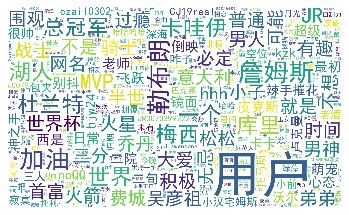

In [160]:
# 词云图
item = 'author'
text = collection.find({}, projection={item: 1, '_id': 0})
if item == 'author':
    text = list(set([i[item] for i in text]))
else:
    text = [i[item] for i in text]
text = '。'.join(text)
# 分词
cut_text = jieba.cut(text)
# 空格拼接
result = ' '.join(cut_text)
# 生成词云图
wc = WordCloud(
    font_path='simhei.ttf',     #字体路径
    background_color='white',   #背景颜色
    width=1000,
    height=600,
    max_font_size=150,            #字体大小
    min_font_size=10,
#     mask=plt.imread('./‪bar.png'),  #背景图片
    max_words=1000
)
wc.generate(result)
wc.to_file('%s.png' % item)    #图片保存

#5.显示图片
plt.figure(item)   #图片显示的名字
plt.imshow(wc)
plt.axis('off')        #关闭坐标
plt.show()

In [3]:
# 连接MongoDB数据库
def conn_mongo():
    client = pymongo.MongoClient(host='localhost', port=27017)
    db = client['spider']
    return client, db

In [ ]:
# 删除mongodb中的重复记录
"""
cmd:mongodump -h 127.0.0.1:27017 -d spider -c hp_post -o D:/zhaokunfeng/Desktop/mongo  # 备份集合
robo 3T:db.hp_post.remove({})  # 清空集合
robo 3T:db.hp_post.createIndex({tid:1},{unique:1,dropDups:1})  # 建立唯一索引
cmd:mongorestore -h 127.0.0.1:27017 -d spider -c hp_post D:/zhaokunfeng/Desktop/mongo/hp_post.bson  # 导入备份
"""

In [ ]:
# 抓取所有可读帖子ID，存入表hp_postid
db = conn_mong()
collection = db['hp_postid']
existed_post = (str(x['post_id']) for x in collection.find())
for link_id in range(27000000, 29475001):
    if link_id in existed_post:
        continue
    try:
        res = requests.get('https://m.hupu.com/bbs/%d.html' % link_id, timeout=5)  # 2700w到29475000
    except Exception as e:
        continue
    if res.status_code == 200:
        collection.insert_one({'post_id': link_id})
    if link_id % 100 == 0:
        time.sleep(0.01)
client.close()

In [ ]:
# 根据帖子ID抓取帖子详情，存入表hp_post
@retry(stop_max_attempt_number=3)  # 最大重试3次
def content(tid):
    res = requests.get('https://m.hupu.com/bbs/%s.html' % tid, timeout=(60, 60))
    return res
        
def post_info(tid):
    post_detail = {}
    try:
        res = content(tid)
#         print(res.text)
    except Exception as e:
        print('无法访问：', tid, e)
        return None
    title = re.search(re.compile('<title>(.*?)</title>.*?', re.S), res.text).group(1)
    try:
        url = re.search(re.compile('HPM.Url = "(.*?)"', re.S), res.text).group(1)
        url = 'https:' + url.replace('\/', '/')
    except:
#         print('返回内容中无法找到URL:', tid)
        db['hp_postid'].remove({'post_id': int(tid)})  # 无权限或被删除
        return
    post_detail['tid'] = int(re.search(re.compile('(\d+)'), url).group(1))
    if db['hp_post'].find({'tid': post_detail['tid']}).count() > 0:
#         print(tid, '真实tid已存在集合hp_post中：', post_detail['tid'])
        return
    try:
        boardName = re.search(re.compile("HPM.boardName = '(.*?)'", re.S), res.text).group(1)
    except:
        boardName = None
    try:
        fid = re.search(re.compile("HPM.fid = '(.*?)'", re.S), res.text).group(1)
    except:
        fid = None
    try:
        times = re.search(re.compile('<span class="times">(.*?)</span>', re.S), res.text).group(1)
    except:
        times = None
    try:
        username = re.search(re.compile("HPM.username = '(.*?)';", re.S), res.text).group(1)
    except:
        username = None
    try:
        puid = re.search(re.compile("HPM.puid = '(.*?)'", re.S), res.text).group(1)
    except:
        puid = None
    try:
        pageCount = int(re.search(re.compile('HPM.pageCount = "(.*?)"', re.S), res.text).group(1))
        if pageCount >= 500:
            print(tid, '回复页数过多：', pageCount, '真实tid:', post_detail['tid'])
    except:
        pageCount = None
    try:
        repliesNum = int(re.search(re.compile("HPM.replies_num='(.*?)';", re.S), res.text).group(1))
    except:
        repliesNum = None
    try:
        lightsNum = int(re.search(re.compile("HPM.lights_num='(.*?)';", re.S), res.text).group(1))
    except:
        lightsNum = None
    replies = []
    if pageCount >= 1:
        for page in range(1, pageCount + 1):
            try:
                new_res = requests.get('%s-%d.html' % (url[:-5], page), timeout=(60, 60))
            except:
                print(tid,'当前页无法访问：', page)
                continue
            try:
                reply = re.search(re.compile('HPM.replies = (\[.*?\]);', re.S), new_res.text).group(1)
            except:
                try:
                    reply = re.search(re.compile('HPM.replies = ({.*?\});', re.S), new_res.text).group(1)
                except:
                    print(tid, '当前页无法找到replies:', page)
                    continue
            if not reply:
                print('reply error:', '%s-%d.html' % (url[:-5], page))
                reply = []
            if reply:
                try:
                    reply = json.loads(reply)
                except:
                    print(tid, '当前页json解析失败：', page)
                    continue
            if isinstance(reply, dict):
                reply = list(reply.values())
            replies = replies + reply
    try:
        articleContent = re.search(re.compile('<article class="article-content">(.*?)</article>', re.S), res.text).group(1)
        articleContent = re.search(re.compile('article-content.*?返回首页.*?</div>(.*?)</article>', re.S), res.text).group(1)
        articleContent = articleContent.strip()
    except:
        print(tid, '无法找到文章内容')
        articleContent = None
    for field in ['url', 'title', 'boardName', 'fid', 'times', 'username', 'puid', 'pageCount',
                 'repliesNum', 'lightsNum', 'articleContent', 'replies']:
        post_detail[field] = vars()[field]
    return post_detail

def crawl_post(i):
    if db['hp_post'].find({'tid': i['post_id']}).count() == 0 and db['hp_invalid_postid'].find({'tid': i['post_id']}).count() == 0:     
        post_detail = post_info(i['post_id'])
        if post_detail and db['hp_post'].find({'tid': post_detail['tid']}).count() == 0:
            try:
                db['hp_post'].insert_one(post_detail)
            except Exception as e:  # mongo限制16M
                try:
                    new_replies = []
                    replies = post_detail['replies']
                    for reply in replies:
                        reply = {k:v for k, v in reply.items() if k in ['via', 'viainfo', 
                                'authorid', 'author', 'author_groups', 'author_level']}
                        if reply['authorid'] not in [i['authorid'] for i in new_replies]:
                            new_replies.append(reply)
                    post_detail['replies'] = new_replies
                    db['hp_post'].insert_one(post_detail)
                except Exception as e:
                    print('数据太大,保存失败', i['post_id'], e)
                    return
        elif not post_detail:
            db['hp_invalid_postid'].insert_one({'tid': i['post_id']})
        else:
            print('tid已存在', post_detail['tid'])
            return
    else:
        return
    
client, db = conn_mongo()
cnt = 0
for i in db['hp_postid'].find({}, no_cursor_timeout=True):
    cnt += 1
    if cnt % 50000 == 0:
        print(cnt)
    crawl_post(i)
client.close()

50000
100000
150000
200000
250000
300000
350000
400000
27700275 当前页无法访问： 1
27712341 当前页无法访问： 1
27725268 当前页无法访问： 1
27729022 当前页无法访问： 1
27729875 当前页无法访问： 1
27737131 当前页无法访问： 1
27744403 当前页无法访问： 26
27744403 当前页无法访问： 27
27744403 当前页无法访问： 28
27744403 当前页无法访问： 29
27744403 当前页无法访问： 30
27744403 当前页无法访问： 31
27744403 当前页无法访问： 32
27744403 当前页无法访问： 33
27744403 当前页无法访问： 34
27744403 当前页无法访问： 35
27744403 当前页无法访问： 36
27744403 当前页无法访问： 37
27744403 当前页无法访问： 38
27744403 当前页无法访问： 39
27744403 当前页无法访问： 40
27744403 当前页无法访问： 41
27744403 当前页无法访问： 42
27744403 当前页无法访问： 43
27744403 当前页无法访问： 44
27744403 当前页无法访问： 45
27744403 当前页无法访问： 46
27744403 当前页无法访问： 47
27744403 当前页无法访问： 48
27744403 当前页无法访问： 49
27744403 当前页无法访问： 50
27744403 当前页无法访问： 51
27744403 当前页无法访问： 52
27744403 当前页无法访问： 53
27744403 当前页无法访问： 54
27744403 当前页无法访问： 55
27744403 当前页无法访问： 56
27744403 当前页无法访问： 57
27744403 当前页无法访问： 58
27744403 当前页无法访问： 59
27744403 当前页无法访问： 60
27744403 当前页无法访问： 61
27744403 当前页无法访问： 62
27744403 当前页无法访问： 63
27744403 当前页无法访问： 64
277444

无法访问： 27744858 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744858.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144BCA7390>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27744859 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744859.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C74E7F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27744861 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744861.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C6ABB70>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27744862 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744862.html 

无法访问： 27744895 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744895.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C7525F8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27744896 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744896.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C752048>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27744897 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744897.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C74E550>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27744898 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27744898.html 

无法访问： 27743332 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27743332.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C752630>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27745804 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745804.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C7521D0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27745805 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745805.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144B978BA8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27745807 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745807.html 

无法访问： 27745869 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745869.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C424278>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745870 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745870.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C7528D0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745872 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745872.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C757240>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745873 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745873.html 

无法访问： 27745015 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745015.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C75C128>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745020 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745020.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C75F320>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745025 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745025.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C7578D0>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745030 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745030.html 

无法访问： 27745149 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745149.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C75F668>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745152 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745152.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C757B70>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745154 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745154.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C75C588>: Failed to establish a new connection: [Errno 11004] getaddrinfo failed'))
无法访问： 27745155 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27745155.html 

无法访问： 27793475 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793475.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C4E10B8>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27793477 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793477.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144C9C7908>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27793480 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793480.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144B978B38>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27793483 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793483.html 

无法访问： 27793550 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793550.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144D8190F0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27793552 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793552.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144D6A5278>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27793558 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793558.html (Caused by NewConnectionError('<urllib3.connection.VerifiedHTTPSConnection object at 0x000002144D4F4EF0>: Failed to establish a new connection: [Errno 11001] getaddrinfo failed'))
无法访问： 27793560 HTTPSConnectionPool(host='m.hupu.com', port=443): Max retries exceeded with url: /bbs/27793560.html 

In [51]:
def query_uid():
    """查询集合hp_post中的uid(repliers)，存入集合hp_uid"""
    client = pymongo.MongoClient('localhost', port=27017)
    db = client['spider']
    user = db['hp_uid']
    post = db['hp_post']
    results = post.find({}, projection={'_id': 0, 'puid': 1, 'replies': 1}, no_cursor_timeout = True)
    cnt = 0
    for result in results:
        cnt += 1
        if cnt % 100 == 0:
            print(cnt // 100)
        uid_set = []
        uid_set.append(result['puid'])
        for reply in result['replies']:
            if reply:
                uid_set.append(reply['authorid'])
        uid_set = list(set(uid_set))
        for puid in uid_set:
            if puid and (user.find({'uid': puid}).count() == 0):
                user.insert_one({'uid': puid})
    client.close()
    print('共查询%d数据' % cnt)
    return

query_uid()

C:\Users\zhaokunfeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.


1
2
共查询208数据


In [ ]:
"""查询集合hp_post中的uid(repliers)，存入集合hp_uid"""  # 方法二
import pandas as pd
import numpy as np
import pymongo
import csv
import time

start = time.time()
filename = 'D:/zhaokunfeng/Desktop/hp_post.csv'
client = pymongo.MongoClient('localhost', 27017)
db = client['spider']
coll = db['hp_post']

results = np.array([])
header = ['authorid']
cnt = 0
with open(filename, 'a+', newline='') as f:
    writer = csv.DictWriter(f, header)
    writer.writeheader()
    for result in coll.find({}, projection={'_id': 0, 'replies.authorid': 1}, no_cursor_timeout=True):
        cnt += 1
        if cnt % 10000 == 0:
            print(cnt)
        writer.writerows(result['replies'])

# 去重
data = pd.read_csv(filename, encoding='gb18030')
data = data.drop_duplicates()
data.to_csv(filename, index=False, encoding='gb18030')

# 存入mongodb
data['authorid'] = data['authorid'].astype(str)
data = data.rename(columns={'authorid': 'uid'}).drop_duplicates('uid')
db['hp_uid'].insert_many(data.to_dict('records'))
client.close()
end = time.time()
print('耗时：', end - start)

In [4]:
# 去重hp_post表中的puid，根据puid抓取用户信息，存入表hp_userinfo
def page_response(url):
    """获取网页源代码"""
    time.sleep(0.1)
    headers = {
#     'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/70.0.3538.77 Safari/537.36',
    'user-agent': choice(AGENTS_ALL)
    'cookie': '_HUPUSSOID=d468983b-5b4c-4bae-a63c-cb892dbf93ec; _CLT=918ebe7bb324d8673460f7af1d701a5c; u=16586251|5YmR6Zeo576B6a2C|ec76|88ca281bca82ab1a1f4203de36676513|ca82ab1a1f4203de|5YmR6Zeo576B6a2C; us=a69dcdc72cd4cc65743a9c595758a7414c7567ea911cfe6c20826a6307a747e4ab74c6e18d4f9d911eb7fdc89d46c8912c3e7d4fe857ae84f996b6b2f4c8f281; ua=30179048; _dacevid3=ed90e3ad.926d.521a.2f02.62cd17cb9654; __dacevst=a0173520.b0a6daac|1569312384736; app_cookie=1569310656; __dacevid3=0xeebd412f2026a098; __dacemvst=586c574d.50173e1d; __dacemvst=586c574d.50173e1d|1569312456661; Hm_lvt_abb0c7fb3fb595c51dc99849b10830bd=1569310657; Hm_lpvt_abb0c7fb3fb595c51dc99849b10830bd=1569310657'
}
    print('start:', url)
    res = requests.get(url, headers=headers, timeout=(3, 7))
    print('end:', '--------------------------------')
    return res.text


def mobile_page_info(uid):
    """移动端用户信息"""
    mobile_url = 'https://m.hupu.com/my/userdetail?uid=%s' % uid
    response = page_response(mobile_url)
#     print(response)
    # nickname,puid,gender,level,cash,online_time,regtime,last_log_time,self_introduction
    mobile_info = {}
    interest = {}
    try:
        puid = re.search(re.compile('<li>.*?>数字ID<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    except:
        return None
    nickname = re.search(re.compile('<li>.*?>昵称<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    gender = re.search(re.compile('<li>.*?>性别<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    level = re.search(re.compile('<li>.*?>论坛等级<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    cash = re.search(re.compile('<li>.*?>银行现金<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    online_time = re.search(re.compile('<li>.*?>在线时长<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    regtime = re.search(re.compile('<li>.*?>注册时间<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    last_log_time = re.search(re.compile('<li>.*?>最后登录时间<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    self_introduction = re.search(re.compile('<li>.*?>自我介绍<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
    try:
        sports = re.search(re.compile('<li>.*?>喜欢的运动<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
        sports = sports.strip('\n').split('\n')
    except:
        sports = None
    try:
        league_match = re.search(re.compile('<li>.*?>喜欢的联赛<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
        league_match = league_match.strip('\n').split('\n')
    except:
        league_match = None
    try:
        teams = re.search(re.compile('<li>.*?>喜欢的队伍<.*?"info">(.*?)</span>.*?</li>', re.S), response).group(1)
        teams = teams.strip('\n').split('\n')
    except:
        teams = None
    for var in ['nickname', 'gender', 'level', 'cash', 'online_time',
                'regtime', 'last_log_time', 'self_introduction']:
        mobile_info[var] = vars()[var]
    for var in ['sports', 'league_match', 'teams']:
        interest[var] = vars()[var]
    info = {'uid': puid, 'baseinfo': mobile_info, 'interests': interest}
    return info


def pc_page_info(uid):
    """网页端用户信息"""
    pc_url = 'https://my.hupu.com/%s' % uid
    response = page_response(pc_url)
    # person_times,prestige,following_num,followers_num,friends_num,collect_post_num, replies_num, daily_reply_num
    # 访问人次，声望，关注人数，粉丝数，好友数，收藏帖子数，回帖数，日均回帖数
    pc_info = {}
    try:
        person_times = re.search(re.compile('mpersonal.*?class="f666">有(.*?)人次访问</span></h3>', re.S), response).group(1)
    except:
        person_times = None
    try:
        prestige = re.search(re.compile('社区声望：.*?reputation" target="_blank">(.*?)</a>	<br/>', re.S), response).group(1)
    except:
        try:
            prestige = re.search(re.compile('<span class="f666">社区声望：</span>(\d+).*?<br/>', re.S), response).group(1)
        except:
            prestige = None
    try:
        following_num, friends_num, followers_num = re.search(re.compile('<p class="more">.*?>关注(.*?)个人.*?>(\d+个好友){0,1}.*?>(.*?)个粉丝.*?/a></p>', re.S), response).groups()
        if not friends_num:
            friends_num = 0
        else:
            friends_num = re.search(re.compile('\d+'), friends_num).group(1)
    except:
        following_num, friends_num, followers_num = None, None, None
    try:
        publish_post_num, replies_num, daily_reply_num = re.search(re.compile('全部(\d+)篇主题帖.*?总共(\d+)帖.*?平均每天(.*?)帖',re.S), response).groups()
    except:
        publish_post_num, replies_num, daily_reply_num = None, None, None
    try:
        collect_post_num = re.search(re.compile('收藏的(\d+)篇帖子', re.S), response).group(1)
    except:
        collect_post_num = '0'
    for var in ['person_times', 'prestige', 'following_num', 'friends_num', 'followers_num',
               'publish_post_num', 'collect_post_num', 'replies_num', 'daily_reply_num']:
        pc_info[var] = vars()[var]
    info = {'summary': pc_info}
    return info


def follow_page_info(response):
    # followers/following/friends
    follower_info = []
    followers = re.findall(re.compile('<p class="user_pic".*?href="(.*?)"><img alt="(.*?)".*?src="https.*?(\d+)_small.*?".*?</a></strong><span>(.*?)</span>', re.S), response)
    for home_url, nickname, uid, detail in followers:
        follower = {}
        follower['uid'] = uid
        follower['nickname'] = nickname
        follower['url'] = home_url
        follower['gender'], follower['address'] = detail.replace(' \u3000', ' ')[1:].split(' ', 1)
        follower_info.append(follower)
    return follower_info


def userinfo(uid):
    """抓取单个用户信息"""
    follower_url = 'https://my.hupu.com/%s/follower' % uid
    following_url = 'https://my.hupu.com/%s/following' % uid
    friend_url = 'https://my.hupu.com/%s/following?gid=1' % uid
    
    pc_info = pc_page_info(uid)
    mobile_info = mobile_page_info(uid)
    follower_res = page_response(follower_url)
    following_res = page_response(following_url)
    friend_res = page_response(friend_url)
    
    follower_info = {'followers': follow_page_info(follower_res)}
    following_info = {'following': follow_page_info(following_res)}
    friend_info = {'friends': follow_page_info(friend_res)}
    
    if not mobile_info:
        return None
    info = mobile_info
    if pc_info:
        info.update(pc_info)
    if follower_info:
        info.update(follower_info)
    if following_info:
        info.update(following_info)
    if friend_info:
        info.update(friend_info)
    
    # 更新数量
    info['summary']['following_num'] = '%d' % len(following_info['following'])
    info['summary']['friends_num'] = '%d' % len(friend_info['friends'])
    info['summary']['followers_num'] = '%d' % len(follower_info['followers'])
    info
    return info

SyntaxError: invalid syntax (<ipython-input-4-d36f1e5da5be>, line 8)

In [ ]:
# 获取集合hp_uid中的uid，抓取userinfo并保存到集合hp_userinfo中
client, db = conn_mongo()
uid_list = db['hp_uid'].find({}, projection={'_id': 0}, no_cursor_timeout = True)
cnt = 0
for i in [{'uid':'220120064384270'}]:#uid_list:
    cnt += 1
    if cnt % 1000 == 0:
        print(cnt)
    uid = i['uid']
    if db['hp_userinfo'].find({'uid': uid}).count() == 0:
        info = userinfo(uid)
        try:
            info = userinfo(uid)
        except:
            print('error', uid)
            continue
        if info:
            print('success')
            db['hp_userinfo'].insert_one(info)
        else:
            print('info is None:', uid)
            continue
#     break
uid_list.close()
existed_uid.close()
client.close()

C:\Users\zhaokunfeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  # Remove the CWD from sys.path while we load stuff.


start: https://my.hupu.com/220120064384270
end: --------------------------------
start: https://m.hupu.com/my/userdetail?uid=220120064384270
end: --------------------------------
start: https://my.hupu.com/220120064384270/follower
end: --------------------------------
start: https://my.hupu.com/220120064384270/following
end: --------------------------------


In [ ]:
# 数据分析：用户画像
# 男女比例，等级分布和排名，银行现金分布和排名，在线时长分布和排名，注册时常分布和排名,发帖时间分布
# ID词云图，title词云图，帖子内容词云图
# 个人兴趣，个人主队